In [1]:
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#Setting up local directories
DIRs_TO_CREATE = ["figures", "results", "temp"]
        
#Directories for outputs
DIRs_TO_CREATE.extend(["../data-processed/Confs/"])

for directory in DIRs_TO_CREATE:
    if not os.path.exists(directory):
        os.makedirs(directory)

The data comes from this paper: https://ps.psychopen.eu/index.php/ps/article/view/9957

For simplicity, the actual data I am using is the concatenation of the active periods.

In [6]:
ROOT_DIR = "../data-raw/Confs/"

contexts = ["conf16", "conf17", "conf18", "conf19"]

conferences = {"conf16":"WS16", "conf17":"ICCSS17", "conf18":"ECSS18", "conf19":"ECIR19"}

colors = {"conf16":"#a6cee3", "conf17":"#1f78b4", "conf18":"#b2df8a", "conf19":"#33a02c"}

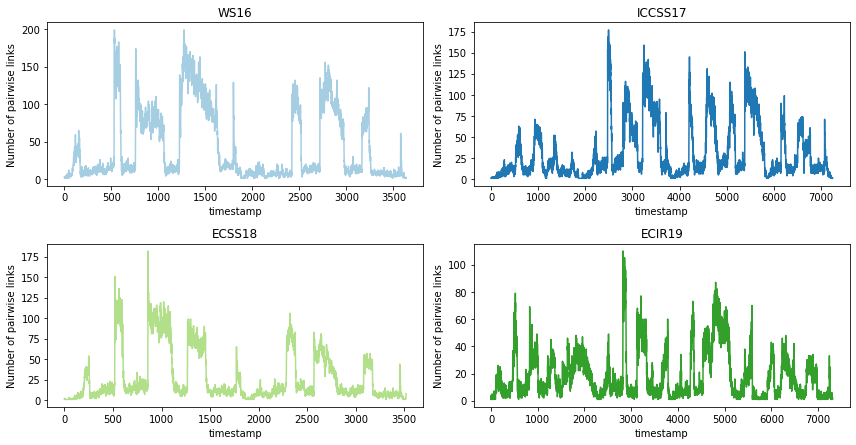

In [18]:
plt.figure(figsize=(12,12))

for i, context in enumerate(contexts):
    df = pd.read_csv(ROOT_DIR+"%s.txt"%context, names=["timestamp", "user_a", "user_b"], sep=" ")
    ax = plt.subplot(4,2,i+1)
    df.groupby("timestamp").size().plot(ax=ax, color=colors[context])
    ax.set_ylabel("Number of pairwise links")
    ax.set_title(conferences[context])
    
plt.tight_layout()

In [3]:
for context in contexts:
    df = pd.read_csv(ROOT_DIR+"%s.txt"%context, names=["timestamp", "user_a", "user_b"], sep=" ")
    print(context, len(df))

conf16 153371
conf17 229536
conf18 96362
conf19 132949


## Temporal aggregation
Differently from the description in the paper, the data has been rescaled so that an increment of 1 timestep corresponds to 20s. I will aggregate to 5min windows = $25\times20s$

In [7]:
#Here I will store the dataframes throughout the processing phases
dfs = {}

window_sampling=25 #20s x 25 = 5min

for context in contexts:
    df = pd.read_csv(ROOT_DIR+"%s.txt"%context, names=["timestamp", "user_a", "user_b"], sep=" ")
    df['agg_timestamp'] = df.apply(lambda row: round(row.timestamp/window_sampling), axis=1)
    df.drop('timestamp', axis=1, inplace=True)
    df.rename(columns={"agg_timestamp": "timestamp"}, inplace=True)
    df.drop_duplicates(inplace=True)
    dfs[context] = df
    print(context, len(df))

conf16 38832
conf17 58745
conf18 24637
conf19 34217


## Adding isolated nodes
I will use the same approach of the other datasets, by denoting isolated nodes as interactions with phatom node -1

**Important NOTE:** Nodes join the dataset at different times, so I should start adding missing nodes as isolated ones only after their first appearance

In [8]:
for context in contexts:
    print(context)
    #Reading the data already temporally sampled
    df = dfs[context]
    
    #New entries containing the isolated nodes that I will append at the end
    entries_to_add = []

    #Set of active nodes in the entire data
    active_nodes = set(df['user_a'].unique()).union(set(df['user_b'].unique()))
    
    #Set of active nodes so far (incremental) -- I will use it to look at the time of joining the data
    active_nodes_up_to_t = set()

    #For each timestep in the selected period...
    for t in df['timestamp'].unique():
        df_t = df[df['timestamp']==t]
        #Set of active nodes at t
        active_nodes_t = set(df_t['user_a'].unique()).union(set(df_t['user_b'].unique()))
        #Adding this set to the cumulative set of active nodes
        active_nodes_up_to_t = active_nodes_up_to_t.union(active_nodes_t)
        #Computing the missing nodes at t
        missing_nodes_t = active_nodes.difference(active_nodes_t)
        #Finally computing the isolate nodes = the missing among those that ever appeared
        isolated_nodes_t = missing_nodes_t.intersection(active_nodes_up_to_t)
        
        #Adding to entries
        for iso_t in isolated_nodes_t:
            entries_to_add.append([t, iso_t, -1])
            
    #Putting the new entries to a dedicated df
    df_isolates = pd.DataFrame(columns=["timestamp", "user_a", "user_b"], data=entries_to_add)

    #Adding them to the final dataframe
    df_with_isolates = pd.concat([df, df_isolates], ignore_index=True)
    
    #Updating the processed dataframe
    dfs[context] = df_with_isolates

conf16
conf17
conf18
conf19


## Saving

In [34]:
for context in contexts:
    df = dfs[context]
    df.to_csv('../data-processed/Confs/%s_processed.csv.gz'%context, index=False, header=True, compression="gzip")

In [5]:
for context in contexts:
    df = pd.read_csv('../data-processed/Confs/%s_processed.csv.gz'%context)
    print(context, len(df))

conf16 46915
conf17 98124
conf18 35124
conf19 61371
